我將老師的模型換掉改做預測小明今天會吃什麼食物

### 1. 讀入深度學習套件&事前準備

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Install HappyML
import os

if not os.path.isdir("HappyML"):
    os.system("git clone https://github.com/cnchi/HappyML.git")

"Meals.csv"是小明某個月的菜單

In [ ]:
# Upload Dataset
Dataset_File = "Meals.csv"

if not os.path.isfile(Dataset_File):
  os.system("wget https://raw.githubusercontent.com/cnchi/datasets/master/" + Dataset_File)

In [ ]:
# Customizable Constants
train_size = 0.75

win_size = 2
sample_step = 1
win_moving = 1

data_batch = 10

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

### 2. 讀入數據

一般自然語言處理, 我們會限制最大要使用的字數。

In [ ]:
# 讀入Meals資料
import HappyML.preprocessor as pp
import numpy as np

dataset = pp.dataset(file="Meals.csv")

# 將日期去掉只留下食物名稱
dataset = pp.onehot_encoder(dataset, columns=[1]).iloc[:, 1:]

In [ ]:
# Keep the One Hot Encoding Mapping
mapper = [s[5:] for s in list(dataset.columns)]

# Convert dataset from DataFrame as NDArray
dataset = dataset.values
train_data, test_data = np.split(dataset, [int(train_size * len(dataset))])

### 3. 資料處理

In [ ]:
# 設定訓練集與測試集
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_set = TimeseriesGenerator(
        data=train_data,
        targets=train_data,
        length=win_size,
        sampling_rate=sample_step,
        stride=win_moving,
        batch_size=data_batch)

test_set = TimeseriesGenerator(
        data=test_data,
        targets=test_data,
        length=win_size,
        sampling_rate=sample_step,
        stride=win_moving,
        batch_size=data_batch)

### 4. step 01: 打造一個函數學習機

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# TO-DO: Add more RNN layers & do the validation set
model = Sequential()
model.add(layers.SimpleRNN(10, input_shape=(win_size, dataset.shape[1])))
model.add(layers.Dense(dataset.shape[1], activation="softmax"))
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

#### 組裝

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

#### 欣賞我們的 model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                150       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 194 (776.00 Byte)
Trainable params: 194 (776.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 5. step 02: 訓練

In [ ]:
model.fit(train_set, batch_size=32, epochs=50)

Epoch 1/50
3/3 [==============================] - 6s 19ms/step - loss: 1.9479 - acc: 0.1905
Epoch 2/50
3/3 [==============================] - 0s 10ms/step - loss: 1.8695 - acc: 0.1905
Epoch 3/50
3/3 [==============================] - 0s 10ms/step - loss: 1.8348 - acc: 0.1905
Epoch 4/50
3/3 [==============================] - 0s 10ms/step - loss: 1.8015 - acc: 0.1905
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 1.7688 - acc: 0.1905
Epoch 6/50
3/3 [==============================] - 0s 10ms/step - loss: 1.7409 - acc: 0.1905
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 1.7202 - acc: 0.1905
Epoch 8/50
3/3 [==============================] - 0s 10ms/step - loss: 1.6898 - acc: 0.1905
Epoch 9/50
3/3 [==============================] - 0s 9ms/step - loss: 1.6625 - acc: 0.1905
Epoch 10/50
3/3 [==============================] - 0s 10ms/step - loss: 1.6435 - acc: 0.1905
Epoch 11/50
3/3 [==============================] - 0s 10ms/step - loss: 1.6188 -

### 6. step 03: 評估

看看模型準確率多少

In [ ]:
# 模型評估
test_loss, test_acc = model.evaluate(test_set)
print("Accuracy of Test Set:", test_acc*100, "%")

1/1 [==============================] - 0s 279ms/step - loss: 0.9593 - acc: 0.5000
Accuracy of Test Set: 50.0 %


### 7. step 04: 測試

實際操作模型看看!

選項有: 煎餃、自助餐、大魯麵、黃金炒飯(字不能打錯)

In [ ]:
# 使用者可以自行輸入資料
from tensorflow.keras.utils import to_categorical

meals = []
meals += [mapper.index(input("請問你前天吃什麼："))]
meals += [mapper.index(input("請問你昨天吃什麼："))]

meals = np.reshape(to_categorical(meals, dataset.shape[1]), (1, win_size, dataset.shape[1]))
meal_today = np.argmax(model.predict(meals), axis=-1)
print("我猜你今天會吃：", mapper[meal_today[0]])

請問你前天吃什麼：煎餃
請問你昨天吃什麼：自助餐
1/1 [==============================] - 0s 222ms/step
我猜你今天會吃： 大魯麵


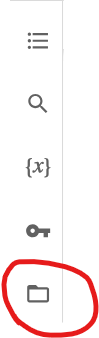可以在左側的檔案夾中打開"Meals.csv"驗證看看RNN有沒有猜對

### 6. 換個存檔方式

這次是把 model 和訓練權重分開存, 使用上更有彈性。

In [ ]:
#from google.colab import drive

#drive.mount('/content/drive')

In [ ]:
#%cd '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#model_json = model.to_json()
#open('imdb_model_architecture.json', 'w').write(model_json)
#model.save_weights('ismdb_model_weights.h5')